In [2]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score

In [44]:
# Analysis of Batch 1

In [3]:
pred = pd.read_csv("../../../data/v4/osm_model_predictions_20_epochs.csv")

In [50]:
annot = pd.read_csv("../../../data/v4/v4_labels.csv")
annot.rename({"id":"image_id"}, axis=1, inplace=True)

In [53]:
len(annot)

1799

In [55]:
annot

,Unnamed: 0,image_id,sequence_id,creator_id,captured_at,highway_osm,surface_osm,smoothness_osm,surface_annotated,smoothness_annotated,highway_annotated
0,0,144246817728733,9eysrLNqdTArOC6ZJcY3HH,106008994971903,1618074081000,residential,asphalt,bad,asphalt,bad,road(car)
1,1,203411474929087,Kcv9ZnyTb2sd6ab8iXMveg,105558841679641,1471014587240,tertiary,asphalt,bad,paving_stones,intermediate,cycleway
2,2,561894621471670,7kHVf95_aGLA6_u75Aoakg,102124648700555,1564340214000,service,asphalt,bad,asphalt,good,road(car)
3,3,3445204625796821,uWjGSNM2IBafoQzC0isRHx,109673317932619,1681905550000,path,asphalt,bad,asphalt,good,path (unspecified)
4,4,774416500991776,A0tgiQ9RGEMz1uvbC4Kj8x,102099175369556,1684429601534,path,asphalt,bad,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1794,1794,152624063537797,zwc9p3a7a8bqorv5azanpp,103049658604940,1561207745755,path,unpaved,very_bad,asphalt,good,path (unspecified)
1795,1795,1261602977627531,hsvAWHFn3USlKI2kJBtpDV,100232345559807,1625472662500,service,unpaved,very_bad,unpaved,intermediate,path (unspecified)
1796,1796,956362611886219,YIBWpZy43laLHE8qrS7Q5F,100474358864037,1628425938404,track,unpaved,very_bad,asphalt,excellent,road(car)
1797,1797,306342574430217,L7A4ZsxVcsqn1z4f0WYoog,100474358864037,1555437447000,track,unpaved,very_bad,unpaved,intermediate,path (unspecified)


In [56]:
annot.groupby(["surface_annotated", "smoothness_annotated"]).size()

surface_annotated  smoothness_annotated
asphalt            bad                      13
                   excellent               234
                   good                    321
                   intermediate             83
concrete           bad                      19
                   excellent                22
                   good                    101
                   intermediate             63
paving_stones      bad                       2
                   excellent                34
                   good                    127
                   intermediate             47
sett               bad                      80
                   good                     20
                   intermediate             87
unpaved            bad                      92
                   intermediate             93
                   very_bad                 25
dtype: int64

In [51]:
df = pred.set_index("image_id").join(annot[["image_id", "surface_annotated", "smoothness_annotated"]].set_index("image_id"), how="left")

In [6]:
NEW_osm_pred = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v4_mapillary_metadata_with_tags_NEW.csv")
NEW_osm_pred = NEW_osm_pred[["id", "surface", "smoothness"]]
NEW_osm_pred.rename({"surface": "surface_osm_NEW", "smoothness": "smoothness_osm_NEW"}, inplace = True, axis = 1)

In [7]:
df = df.join(NEW_osm_pred.set_index("id"), how = "left")

In [8]:

def clean_smoothness(smoothness):
    """Clean smoothness column of metadata dataframe according to defined OSM smoothness values

    Args:
        metadata (df): dataframe with image metadata, including column "smoothness"

    Returns:
        df: dataframe with cleaned smoothness column "smoothness_clean"
    """
    smoothness = smoothness.str.strip()
    smoothness_clean = smoothness.replace(
        [
            "horrible",
            "very_horrible",
            "impassable",
            "very bad"
        ],
        "very_bad",
    )

    smoothness_clean = smoothness_clean.replace(
        ["perfect", "very_good"], "excellent"
    )
    return smoothness_clean


def clean_surface(surface):
    """Clean surface column of metadata dataframe according to defined OSM surface values

    Args:
        metadata (df): dataframe with image metadata, including column "surface"

    Returns:
        df: dataframe with cleaned surface column "surface_clean"
    """
    surface = surface.str.strip()
    surface_clean = surface.replace(
        [
            "compacted",
            "gravel",
            "ground",
            "fine_gravel",
            "dirt",
            "grass",
            "earth",
            "sand",
        ],
        "unpaved",
    )
    surface_clean = surface_clean.replace(
        ["cobblestone", "cobblestone:flattened", "unhewn_cobblestone"], "sett"
    )
    surface_clean = surface_clean.replace(
        ["concrete:plates", "concrete:lanes"], "concrete",
    )
    return surface_clean

In [9]:
# compute new intersection stats
df = df[df.surface_osm_NEW.notna()]
df = df[df.smoothness_osm_NEW.notna()]
df.surface_osm_NEW = clean_surface(df.surface_osm_NEW)
df.smoothness_osm_NEW = clean_surface(df.smoothness_osm_NEW)

In [10]:
df_only_streets = df[~df.surface_annotated.isna()]
#df = df_only_streets

In [11]:
df.loc[df.surface_annotated.isna(), "surface_annotated"] = "nostreet"
#df.loc[df.class_probability < 0.95, "model_prediction"] = "nostreet"

In [12]:
df["combined_prediction"] = "no prediction"
df.loc[df.model_prediction == df.osm_prediction, "combined_prediction"] = df[df.model_prediction == df.osm_prediction].model_prediction

In [13]:
df[df.surface_annotated.notna() & df.smoothness_annotated.notna()].groupby(["surface_annotated", "smoothness_annotated"]).size()

surface_annotated  smoothness_annotated
asphalt            bad                       5
                   excellent                90
                   good                    131
                   intermediate             36
concrete           bad                      10
                   excellent                12
                   good                     50
                   intermediate             24
paving_stones      excellent                13
                   good                     62
                   intermediate             18
sett               bad                      44
                   good                     10
                   intermediate             37
unpaved            bad                      33
                   intermediate             41
                   very_bad                  7
dtype: int64

#### Accuracies

In [14]:
# accurary of CNN model
df[df.model_prediction == df.surface_annotated].shape[0] / df.shape[0]

0.7994652406417112

CNN Model reaches accuracy of 79% (including "no street")

In [15]:
df_only_streets[df_only_streets.model_prediction == df_only_streets.surface_annotated].shape[0] / df_only_streets.shape[0]

0.9598715890850722

If only images are considered, that are not classified as "nostreet" by the annotators, the accuracy is 0.96%.

In [16]:
class_prb = 0.99
df[(df.class_probability > class_prb) & (df.model_prediction == df.surface_annotated)].shape[0] / df[(df.class_probability > class_prb)].shape[0]

0.8870370370370371

If only high prob predictions are considered, the accuracy of the CNN model is 0.89%.

In [17]:
# how much percent of images has only high class probability?
len(df[(df.class_probability > class_prb)]) / len(df)

0.7219251336898396

In [18]:
# accurary of osm 
df[df.osm_prediction == df.surface_annotated].shape[0] / df.shape[0]

0.5641711229946524

In [19]:
df[df.surface_osm_NEW == df.surface_annotated].shape[0] / df.shape[0]

0.5735294117647058

OSM labels have an accuracy of 56%.

In [20]:
df_only_streets[df_only_streets.osm_prediction == df_only_streets.surface_annotated].shape[0] / df_only_streets.shape[0]

0.6773675762439807

In [21]:
df_only_streets[df_only_streets.surface_osm_NEW == df_only_streets.surface_annotated].shape[0] / df_only_streets.shape[0]

0.6886035313001605

In [22]:
# by surface:
for surface in df_only_streets.surface_annotated.unique():
    temp = df_only_streets[(df_only_streets.osm_prediction == surface)]
    print(surface)
    print(round(temp[temp.surface_osm_NEW == temp.surface_annotated].shape[0] / temp.shape[0],2))

asphalt
0.94
sett
0.54
concrete
0.57
paving_stones
0.54
unpaved
0.9


In [52]:
# accuracy of smoothness

In [23]:
correct_type = df[df.surface_osm_NEW == df.surface_annotated]

In [24]:
correct_type[correct_type.smoothness_osm_NEW == correct_type.smoothness_annotated].shape[0] / correct_type.shape[0]

0.5501165501165501

In [25]:
# by surface:
for surface in df_only_streets.surface_annotated.unique():
    temp = df_only_streets[(df_only_streets.osm_prediction == surface)]
    print(surface)
    print(round(temp[temp.osm_prediction == temp.surface_annotated].shape[0] / temp.shape[0],2))

asphalt
0.94
sett
0.51
concrete
0.57
paving_stones
0.52
unpaved
0.89


In [26]:
# by surface:
for surface in df_only_streets.surface_annotated.unique():
    temp = df_only_streets[(df_only_streets.surface_osm_NEW == surface)]
    print(surface)
    print(round(temp[temp.surface_osm_NEW == temp.surface_annotated].shape[0] / temp.shape[0],2))

asphalt
0.91
sett
0.53
concrete
0.57
paving_stones
0.54
unpaved
0.9


If only images are considered, that are not classified as "nostreet" by the annotators, the accuracy of OSM labels is 68%.

In [27]:
# incorrect labels of OSM predictions have the following annotated surfaces:
df_only_streets[df_only_streets.osm_prediction != df_only_streets.surface_annotated].surface_annotated.value_counts(normalize=True)

surface_annotated
asphalt          0.631841
sett             0.174129
paving_stones    0.134328
concrete         0.039801
unpaved          0.019900
Name: proportion, dtype: float64

There is an overrepresentation of Asphalt in the incorrect OSM labels. Also, many images are "nostreet", i.e., cannot be classfied properly.

In [28]:
# accuracy of combined model
df[df.combined_prediction == df.surface_annotated].shape[0] / df.shape[0]

0.5401069518716578

The combined prediction has an accuracy of 53%, if all images (including "nostreet") are considered. 
However, more interesting is the accuracy if a combined prediction is present:

In [29]:
# accuracy if a combined prediction is present
df[df.combined_prediction != "no prediction"][df.combined_prediction == df.surface_annotated].shape[0] / df[df.combined_prediction != "no prediction"].shape[0]

/var/folders/m7/jb7xk8h91p541g43zv2r8l740000gn/T/ipykernel_61432/1833379915.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.combined_prediction != "no prediction"][df.combined_prediction == df.surface_annotated].shape[0] / df[df.combined_prediction != "no prediction"].shape[0]


0.8898678414096917

In [30]:
# by surface:
for surface in df_only_streets.surface_annotated.unique():
    temp = df[(df.combined_prediction == surface)]
    print(surface)
    print(round(temp[temp.combined_prediction == temp.surface_annotated].shape[0] / temp.shape[0],2))

asphalt
0.93
sett
0.84
concrete
0.91
paving_stones
0.91
unpaved
0.82


In [31]:
# how many have a combined prediction?
len(df[df.combined_prediction != "no prediction"])

454

In [32]:
len(df[df.combined_prediction != "no prediction"]) / len(df)

0.606951871657754

Th accuracy of the combined prediction is 89%. This includes 61% of all images.

In [33]:
# how many images have a combined prediction?
df.combined_prediction.value_counts(normalize=True)

combined_prediction
no prediction    0.393048
asphalt          0.185829
concrete         0.121658
unpaved          0.121658
paving_stones    0.092246
sett             0.085561
Name: proportion, dtype: float64

Distibution of combined predictions is not entirely even: espsecially sett and paving stones are underrepresented. 
However, the distribution is much more even than in the population.

In [34]:
# Extract predicted and ground truth values
y_true = df['surface_annotated']
y_pred = df['combined_prediction']

# Compute precision and recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Display the results
# print("Precision:", precision)
# print("Recall:", recall)

labels = df['surface_annotated'].unique()

for class_name in labels:
    if class_name == "nostreet":
        continue
    class_precision = precision_score(y_true == class_name, y_pred == class_name)
    class_recall = recall_score(y_true == class_name, y_pred == class_name)

    print(f"Class: {class_name}")
    print(f"Count in combined prediction: {len(y_pred[y_pred == class_name])}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")


Class: asphalt
Count in combined prediction: 139
Precision: 0.93
Recall: 0.49
------------------------
Class: sett
Count in combined prediction: 64
Precision: 0.84
Recall: 0.59
------------------------
Class: concrete
Count in combined prediction: 91
Precision: 0.91
Recall: 0.86
------------------------
Class: paving_stones
Count in combined prediction: 69
Precision: 0.91
Recall: 0.68
------------------------
Class: unpaved
Count in combined prediction: 91
Precision: 0.82
Recall: 0.93
------------------------


/Users/alexandra/opt/anaconda3/envs/sai_dc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexandra/opt/anaconda3/envs/sai_dc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
pd.DataFrame(df.groupby(["surface_annotated", "combined_prediction"]).size())

0
surface_annotated combined_prediction     
asphalt           asphalt              129
                  no prediction        133
concrete          concrete              83
                  no prediction         13
nostreet          asphalt                9
                  concrete               8
                  no prediction         76
                  paving_stones          6
                  sett                  10
                  unpaved               16
paving_stones     no prediction         30
                  paving_stones         63
sett              no prediction         37
                  sett                  54
unpaved           asphalt                1
                  no prediction          5
                  unpaved               75

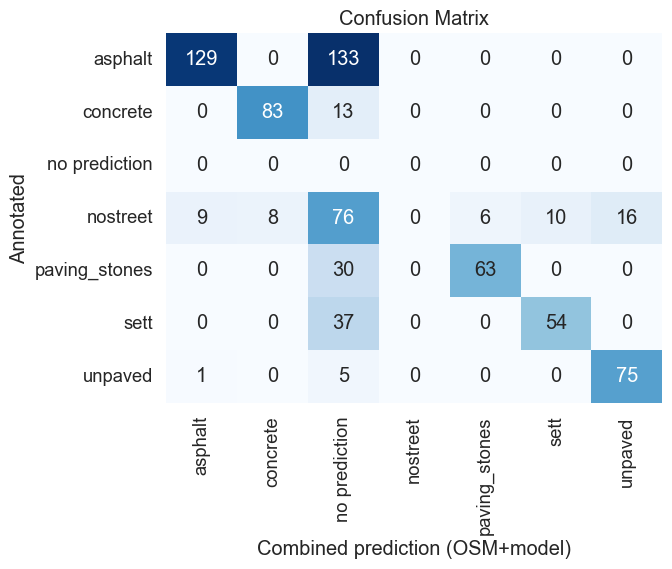

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true.values, y_pred.values)

# Plotting the confusion matrix using seaborn heatmap
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "no prediction", "nostreet", "paving_stones", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "no prediction", "nostreet", "paving_stones", "sett", "unpaved"])
plt.title("Confusion Matrix")
plt.xlabel("Combined prediction (OSM+model)")
plt.ylabel("Annotated")
plt.show()

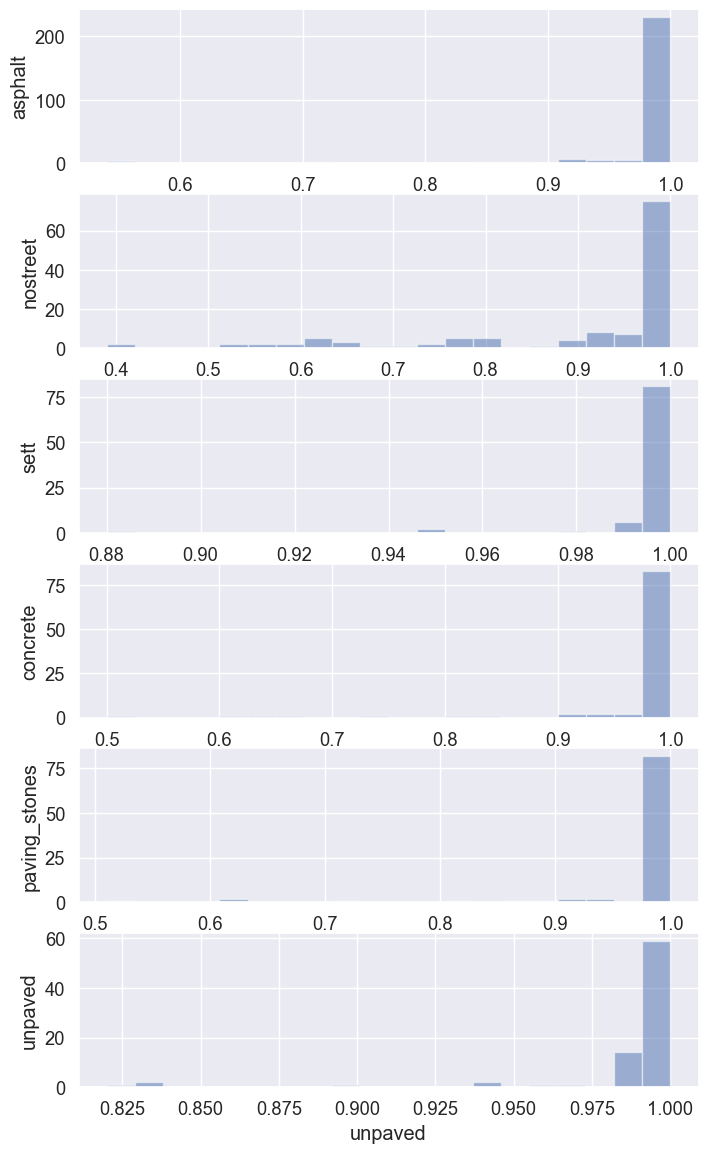

In [37]:
import matplotlib.pyplot as plt

# Create histograms for each class in the "surface" column as subplots
classes = df['surface_annotated'].unique()
num_classes = len(classes)

plt.figure(figsize=(8, 14))  # Set the figure size

for i, class_name in enumerate(classes, 1):
    class_data = df[df['surface_annotated'] == class_name]
    
    plt.subplot(num_classes, 1, i)
    plt.hist(class_data.class_probability, bins=20, alpha=0.5, label=class_name)
    
    plt.xlabel(f'{class_name}')
    plt.ylabel(f'{class_name}')

In [38]:
counts_no_prediction = df[df.combined_prediction == "no prediction"].surface_annotated.value_counts(sort=False)
counts_no_prediction

surface_annotated
asphalt          133
nostreet          76
sett              37
concrete          13
paving_stones     30
unpaved            5
Name: count, dtype: int64

In [39]:
counts_all = df.surface_annotated.value_counts(sort=False)
counts_all

surface_annotated
asphalt          262
nostreet         125
sett              91
concrete          96
paving_stones     93
unpaved           81
Name: count, dtype: int64

In [40]:
counts_no_prediction / counts_all

surface_annotated
asphalt          0.507634
nostreet         0.608000
sett             0.406593
concrete         0.135417
paving_stones    0.322581
unpaved          0.061728
Name: count, dtype: float64

We mostly lose asphalt and those where we could not make a prediction.

In [41]:
smoothness_all = df.smoothness_annotated.value_counts(sort=False)
smoothness_all

smoothness_annotated
excellent       115
bad              92
good            253
intermediate    156
very_bad          7
Name: count, dtype: int64

In [42]:
smoothness_no_prediction = df[df.combined_prediction == "no prediction"].smoothness_annotated.value_counts(sort=False)

In [43]:
smoothness_no_prediction / smoothness_all

smoothness_annotated
bad             0.315217
excellent       0.495652
good            0.403162
intermediate    0.192308
very_bad             NaN
Name: count, dtype: float64